### Setup

In [1]:
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
import os
import torch
import transformer_lens
import random

from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import generate_example, parse_example, GraphDataset
from utils import *
from interp_utils import *

### Model Training

13>15,12>6,8>3,15>10,12>1,15>5,13>14,2>13,0>7,7>9,9>8,11>4,10>0,0>12,14>11|4:2>13>14>11>4


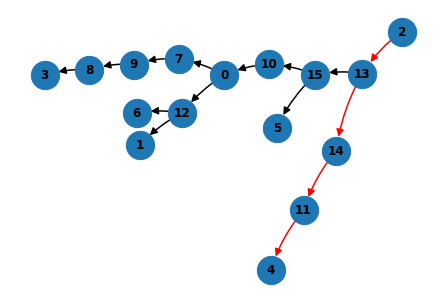

In [2]:
# You can generate an example tree using this function
ex = generate_example(16, 0)
print(ex)

# You can visualize an example using this function (as long as the tree is valid)
parse_example(ex)

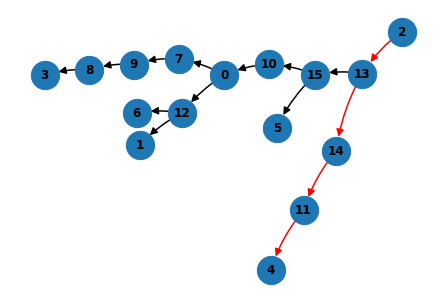

In [3]:
n_examples = 172_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)
train_loader, test_loader = get_loaders(dataset, 32)

In [4]:
for tokens, masks in test_loader:
    for i in range(tokens.shape[0]):
        t = tokens[i]
        m = masks[i]
        print("Prompt:", dataset.untokenize(t[~m]))
        print("Completion:", dataset.untokenize(t[m]), end="\n\n")
    break

Prompt: 1>11,14>0,13>15,8>5,10>1,11>7,9>14,9>13,7>9,3>4,0>12,4>6,12>2,5>10,7>3|6:8
Completion: >5>10>1>11>7>3>4>6

Prompt: 2>7,1>12,5>9,3>2,0>10,9>8,6>4,0>11,5>14,1>13,5>1,14>6,7>15,10>5,7>0|4:3
Completion: >2>7>0>10>5>14>6>4

Prompt: 12>14,1>5,5>6,0>2,11>13,13>8,10>4,7>10,9>15,3>1,8>0,7>9,7>12,5>7,0>3|14:11
Completion: >13>8>0>3>1>5>7>12>14

Prompt: 14>15,5>4,4>8,15>6,3>10,10>12,5>0,13>11,3>13,14>9,7>3,14>2,10>5,6>7,10>1|8:14
Completion: >15>6>7>3>10>5>4>8

Prompt: 11>3,13>9,0>13,6>4,2>15,13>8,0>11,5>10,7>0,1>7,3>6,8>2,0>14,11>5,13>12|10:1
Completion: >7>0>11>5>10

Prompt: 9>8,4>6,7>1,8>7,3>12,4>15,4>11,11>0,5>14,9>4,9>13,0>5,10>3,12>9,10>2|14:10
Completion: >3>12>9>4>11>0>5>14

Prompt: 14>1,12>14,3>10,5>15,7>4,10>5,15>13,7>11,8>12,10>6,10>8,3>9,9>7,3>0,6>2|0:3
Completion: >0

Prompt: 5>8,4>9,1>14,13>4,14>3,12>5,7>10,14>0,8>6,4>15,9>1,5>11,11>7,12>2,9>12|2:13
Completion: >4>9>12>2

Prompt: 13>10,5>11,6>0,6>8,15>12,6>5,9>1,3>2,15>13,5>3,12>4,1>15,14>7,7>9,3>14|0:6
Completion: >0

Promp

In [5]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


In [6]:
# Load in the model if weights are in the directory, else train new model
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt"))
else:
    train(model, train_loader, test_loader, n_epochs=100, learning_rate=3e-4)
    torch.save(model.state_dict(), "model.pt")

In [7]:
start_seed = 250_000
num_samples = 1_000

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 98.8000%
random: 99.9000%


9>8,2>9,7>10,1>2,1>7,14>1,6>14,11>12,11>0,3>6,5>11,5>3,4>5,15>4,13>15|8:13>15>4>5>3>6>14>1>2>9>8


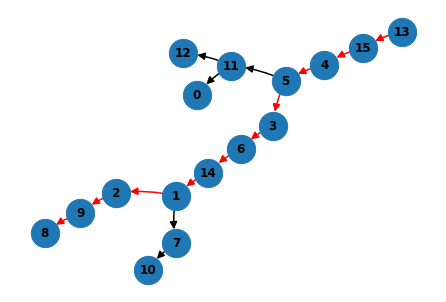

In [16]:
test_graph = generate_example(n_states, np.random.randint(400_000, 600_000), order="backward")
pred, correct = eval_model(model, dataset, test_graph)
if correct:
    parse_example(pred)
labels, cache = get_example_cache(pred, model, dataset)
print(pred)

In [17]:
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)

### Experiment: Attention Blockout ACDC

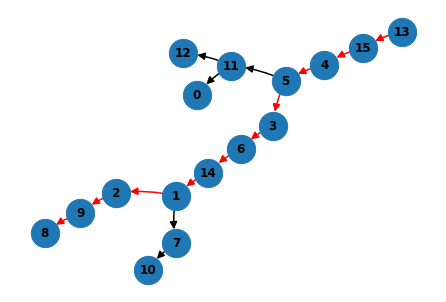

In [18]:
model.reset_hooks()
parse_example(test_graph)

In [19]:
ablated_edges, important_edges = attention_knockout_discovery(model, dataset, test_graph)

Breaking: Layer 5 head 0, labels[47] attending to labels[37], 13 attending to >5
Breaking: Layer 5 head 0, labels[47] attending to labels[16], 13 attending to >1
Breaking: Layer 5 head 0, labels[47] attending to labels[4], 13 attending to >9
Breaking: Layer 5 head 0, labels[47] attending to labels[2], 13 attending to ,
Breaking: Layer 5 head 0, labels[47] attending to labels[1], 13 attending to >8
Breaking: Layer 5 head 0, labels[47] attending to labels[0], 13 attending to 9
Breaking: Layer 5 head 0, labels[48] attending to labels[37], >15 attending to >5
Breaking: Layer 5 head 0, labels[50] attending to labels[13], >5 attending to >7
Breaking: Layer 5 head 0, labels[51] attending to labels[1], >3 attending to >8
Breaking: Layer 5 head 0, labels[56] attending to labels[10], >9 attending to >2
Breaking: Layer 5 head 0, labels[56] attending to labels[8], >9 attending to ,
Breaking: Layer 5 head 0, labels[56] attending to labels[7], >9 attending to >10
Breaking: Layer 5 head 0, labels[56]

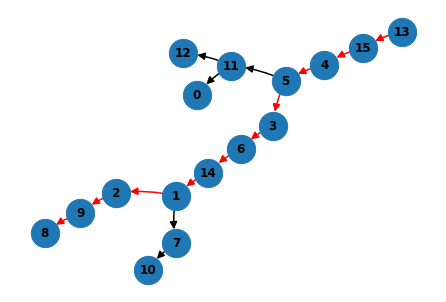

In [24]:
model.reset_hooks()

for L in ablated_edges.keys():
    inds = ablated_edges[L]
    if len(inds) == 0:
        continue
    add_attention_blockout_parallel(model, L, inds)

pred, correct = eval_model(model, dataset, test_graph)
if correct:
    parse_example(pred)
labels, cache = get_example_cache(pred, model, dataset)

In [25]:

for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)


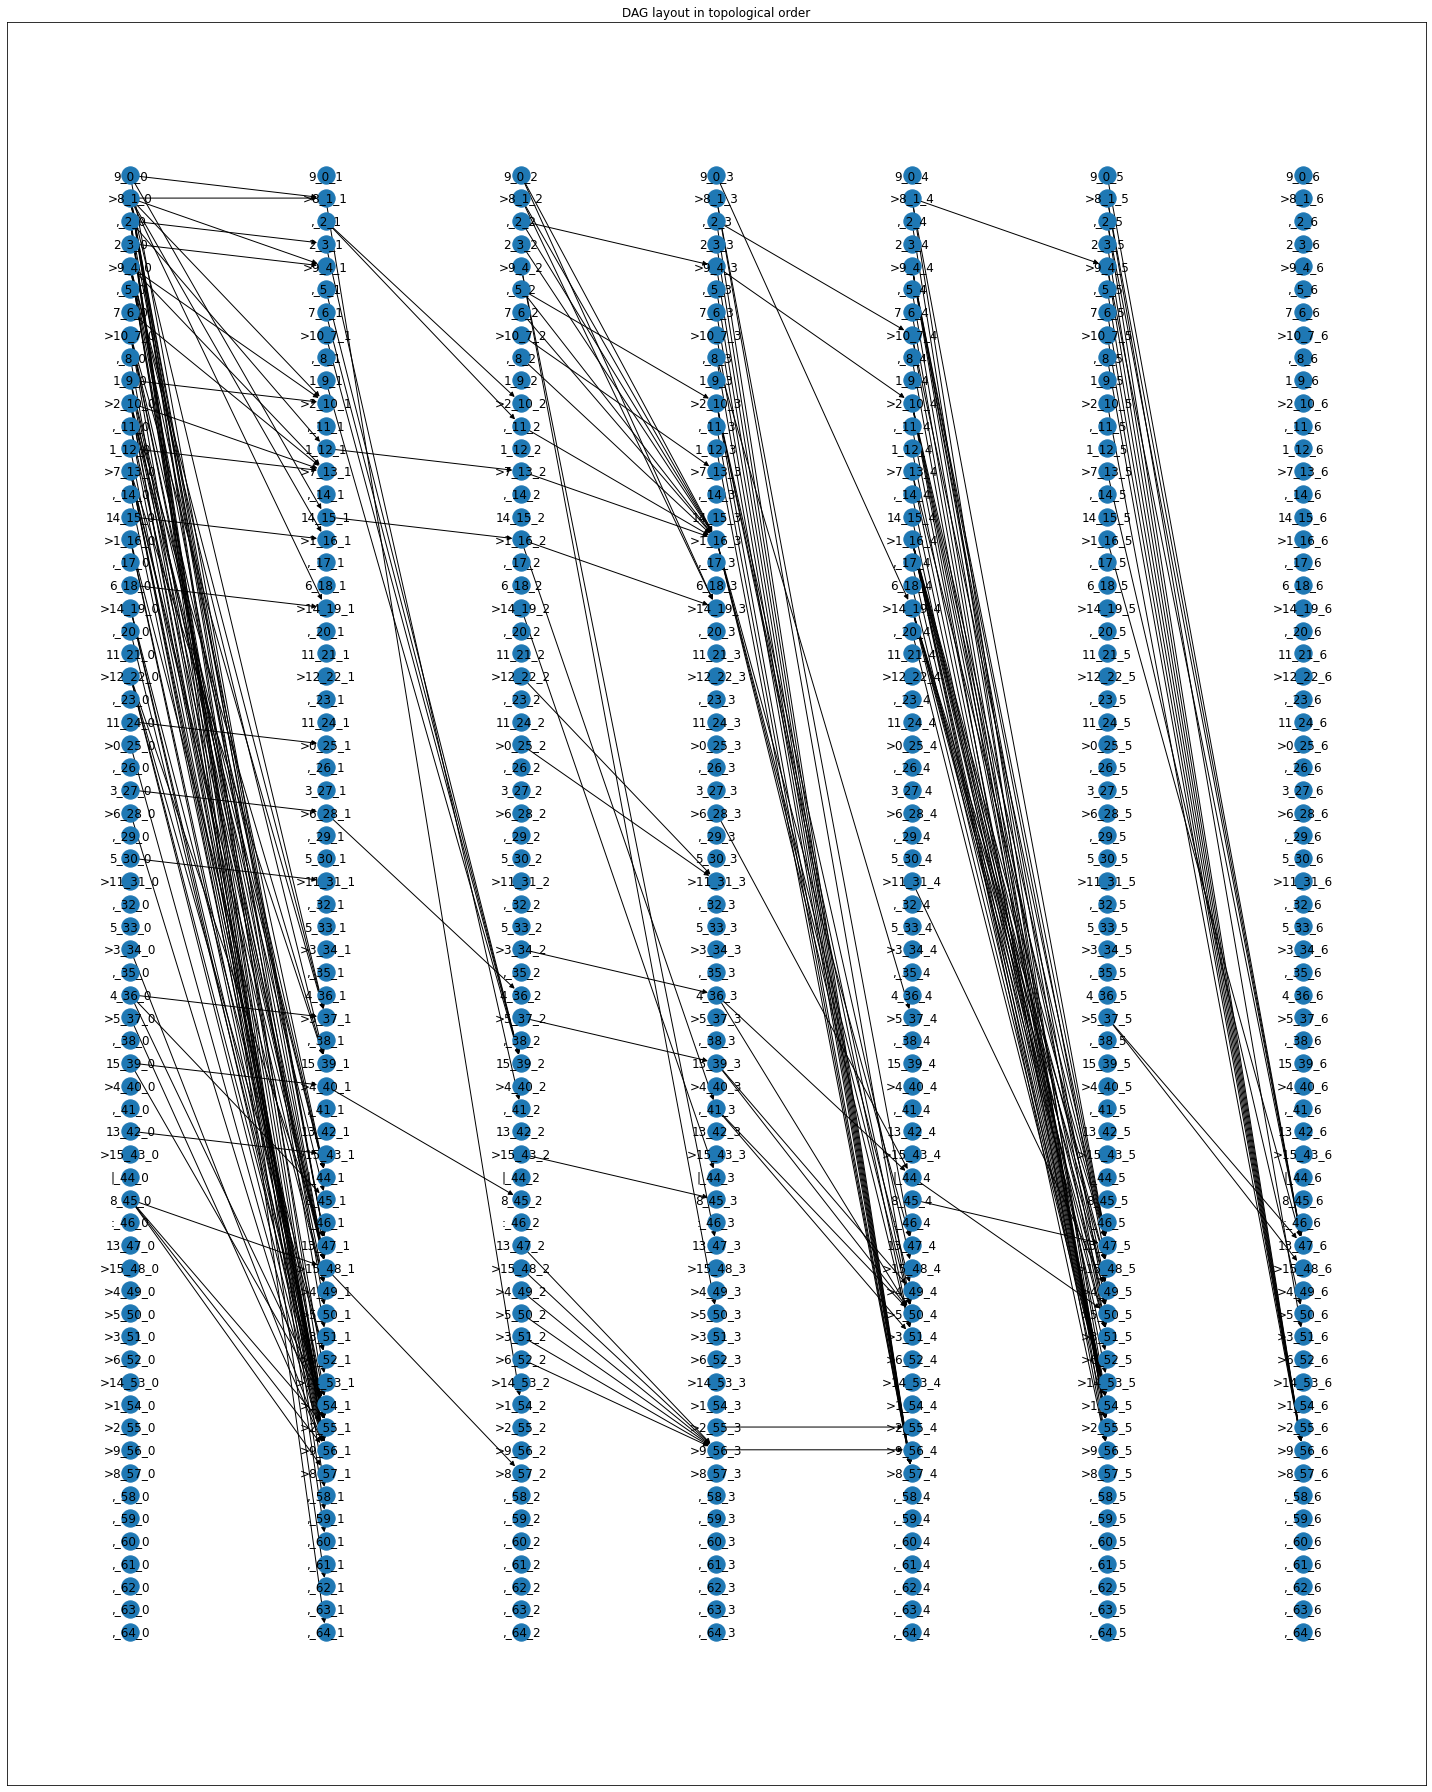

In [26]:
G = nx.DiGraph()

for pos, label in enumerate(labels):
    for layer in range(model.cfg.n_layers+1):
        G.add_node(f"{label}_{pos}_{layer}", layer=layer)

for L in important_edges.keys():
    for h, curr, attend in important_edges[L]:
        G.add_edge(f"{labels[attend]}_{attend}_{L}", f"{labels[curr]}_{curr}_{L+1}")


# Compute the multipartite_layout using the "layer" node attribute
pos = nx.multipartite_layout(G, subset_key="layer")

fig, ax = plt.subplots(figsize=(20, 25))
nx.draw_networkx(G, pos=pos, ax=ax)
ax.set_title("DAG layout in topological order")
fig.tight_layout()
plt.show()

### Experiment: Tuned Lens

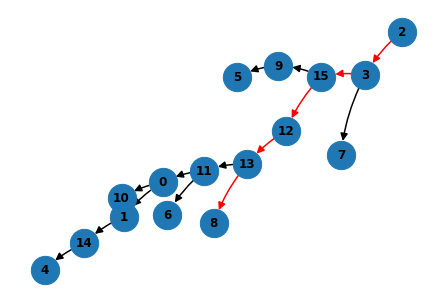

In [10]:
test_graph = generate_example(n_states, np.random.randint(400_000, 600_000), order="backward")
pred, correct = eval_model(model, dataset, test_graph)
if correct:
    parse_example(pred)

In [11]:
logit_lens(pred, model, dataset)

### Experiment: Looking at Embeddings

In [12]:
embedding_matrix = model.W_E.detach().cpu().numpy()
embedding_matrix = embedding_matrix - embedding_matrix.mean(axis=-1, keepdims=True)

# Compute L2 norm for each row
row_norms = np.linalg.norm(embedding_matrix, axis=1, keepdims=True)
embedding_matrix = embedding_matrix / row_norms

incoming_embeddings = embedding_matrix[3:19]
outgoing_embeddings = embedding_matrix[19:]
all_nodes = embedding_matrix[3:]

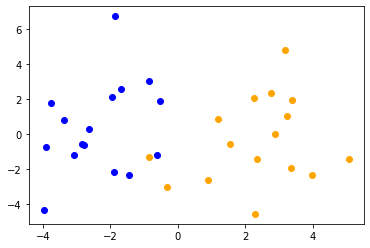

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume that 'data' is your original dataset
scaler = StandardScaler()
data_scaled = scaler.fit_transform(all_nodes)

pca = PCA(n_components=2)  # k is the desired number of components
data_transformed = pca.fit_transform(data_scaled)

fig, ax = plt.subplots()

plt.scatter(data_transformed[:16, 0], data_transformed[:16, 1], color="blue")
plt.scatter(data_transformed[16:, 0], data_transformed[16:, 1], color="orange")

### Experiment: Probing


In [14]:
X, graphs = aggregate_activations(
    model=model,
    dataset=dataset,
    activation_keys=[utils.get_act_name("v", i, "attn") for i in range(0, 6)],
    n_states=n_states,
    n_samples=1_024
)

for key in X.keys():
   tensor_list = [ x[0, [i for i in range(45) if (i-1) % 3 == 0], 0] for x in X[key] ]
   X[key] = torch.cat(tensor_list, dim=0).detach().cpu().numpy()

In [15]:
from sklearn import preprocessing
y = {"incoming": [], "outgoing": []}

for graph in graphs:
    tokens = dataset.tokenize(graph)[:-1]
    labels = [dataset.idx2tokens[idx] for idx in tokens]
    y["outgoing"].append([labels[i-1] for i in range(45) if (i-1)%3 == 0])
    y["incoming"].append([labels[ i ] for i in range(45) if (i-1)%3 == 0])

y["incoming"] = preprocessing.LabelEncoder().fit_transform( np.array(y["incoming"]).flatten() )
y["outgoing"] = preprocessing.LabelEncoder().fit_transform( np.array(y["outgoing"]).flatten() )

In [16]:
for xkey in X.keys():    
    for ykey in y.keys():
        score = linear_probing(X[xkey], y[ykey])
        print(f"Layer {xkey.split('.')[1]} {ykey} node probe - {score:.3f}")

Layer 0 incoming node probe - 1.000
Layer 0 outgoing node probe - 0.080
Layer 1 incoming node probe - 1.000
Layer 1 outgoing node probe - 1.000
Layer 2 incoming node probe - 1.000
Layer 2 outgoing node probe - 1.000
Layer 3 incoming node probe - 1.000
Layer 3 outgoing node probe - 1.000
Layer 4 incoming node probe - 1.000
Layer 4 outgoing node probe - 1.000
Layer 5 incoming node probe - 1.000
Layer 5 outgoing node probe - 1.000


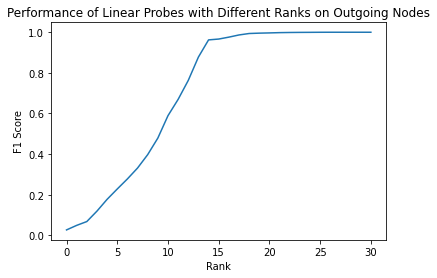

In [17]:
scores = []
for rank in range(1, 32):
    score = linear_probing(X[utils.get_act_name("v", 5, "attn")], y["outgoing"], rank=rank)
    scores.append(score)

plt.plot(scores)
plt.title("Performance of Linear Probes with Different Ranks on Outgoing Nodes")
plt.xlabel("Rank")
plt.ylabel("F1 Score")
plt.show()

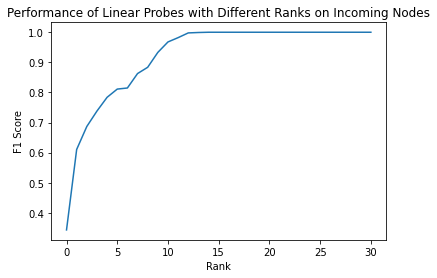

In [18]:
scores = []
for rank in range(1, 32):
    score = linear_probing(X[utils.get_act_name("v", 5, "attn")], y["incoming"], rank=rank)
    scores.append(score)

plt.plot(scores)
plt.title("Performance of Linear Probes with Different Ranks on Incoming Nodes")
plt.xlabel("Rank")
plt.ylabel("F1 Score")
plt.show()

### Experiment: Low Rank Approximation of Attention

In [19]:
from functools import partial


def add_low_rank_hook(layer, k):
    pca = PCA(n_components=k)  # k is the desired rank of the approximation
    pca = pca.fit(X[utils.get_act_name("v", layer, "attn")])

    # Add low-rank hook
    def low_rank_hook(
            resid_pre,
            hook,
            position):
        # Each HookPoint has a name attribute giving the name of the hook.
        np_resid = resid_pre[:, position, 0, :].detach().cpu().numpy()
        b, p, d = np_resid.shape
        low_rank = pca.transform(np_resid.reshape(b*p, d))
        inv_low_rank = pca.inverse_transform(low_rank).reshape(b, p, d)
        resid_pre[:, position, 0, :] = torch.from_numpy(inv_low_rank).cuda()
        return resid_pre

    temp_hook_fn = partial(low_rank_hook, position=[i for i in range(45) if (i-1) % 3 == 0])
    model.blocks[layer].attn.hook_v.add_hook(temp_hook_fn)

In [20]:
model.reset_hooks()
n_pca = 20

add_low_rank_hook(3, n_pca)
add_low_rank_hook(4, n_pca)
add_low_rank_hook(5, n_pca)

In [21]:
start_seed = 250_000
num_samples = 1_000

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 98.7000%
random: 99.9000%


### Experiment: Activation Patching

In [22]:
def generate_goal_distance_examples(distance):
    # Generate clean and corrupted prompts
    clean_prompt = "0>1,1>2,2>3,3>4,4>5,5>6,6>7,7>8,8>9,9>10,10>11,11>12,12>13,13>14,14>15|15:0>1>2>3>4>5>6>7>8>9>10>11>12>13>14>15"
    edges = [f"{i}>{i+1}" for i in range(15 - distance - 1)] + [f"{15 - distance - 1}>{15 - distance}", f"{15 - distance - 1}>{15 - distance + 1}"] + [f"{i}>{i+1}" for i in range(15 - distance + 1, 15)]
    path = '>'.join([str(x) for x in range(16) if x != 15 - distance])
    corrupted_prompt = ",".join(edges) + "|" + f"{15}:{path}"
    return clean_prompt, corrupted_prompt


def goal_distance_activation_patching(distance):
    # Generate clean and corrupted prompts
    clean_prompt, corrupted_prompt = generate_goal_distance_examples(distance)
    parse_example(clean_prompt)
    plt.show()
    parse_example(corrupted_prompt)
    plt.show()
    # Tokenize
    clean_tokens = torch.from_numpy(dataset.tokenize(clean_prompt)[0:-1]).cuda()
    corrupted_tokens = torch.from_numpy(dataset.tokenize(corrupted_prompt)[0:-1]).cuda()
    patching_result = activation_patching(model, dataset, clean_tokens, corrupted_tokens, 46 + (15 - distance + 1) )
    return patching_result, clean_tokens

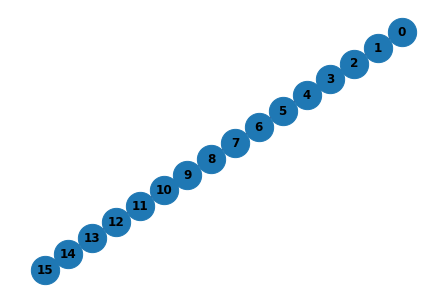

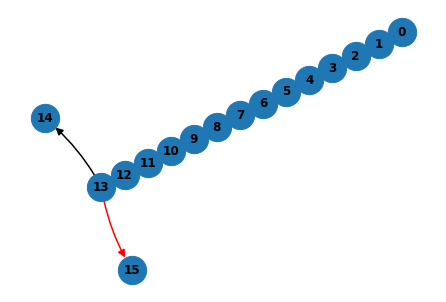

Clean logit difference: 28.632
Corrupted logit difference: -26.726
Positive Direction: >14
Negative Direction: >15


  0%|          | 0/6 [00:00<?, ?it/s]

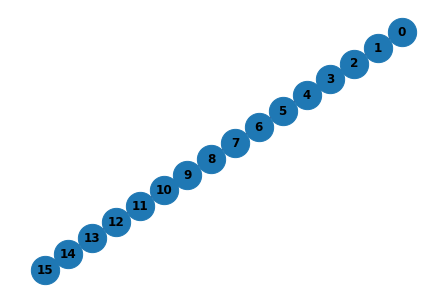

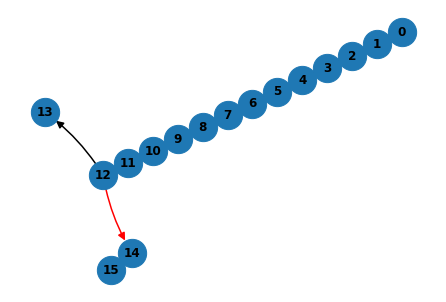

Clean logit difference: 20.599
Corrupted logit difference: -31.021
Positive Direction: >13
Negative Direction: >14


  0%|          | 0/6 [00:00<?, ?it/s]

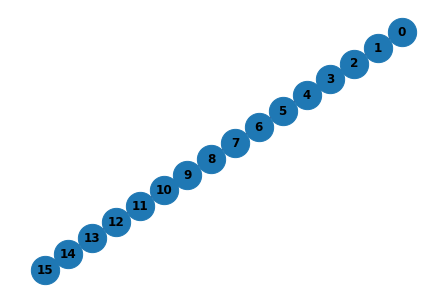

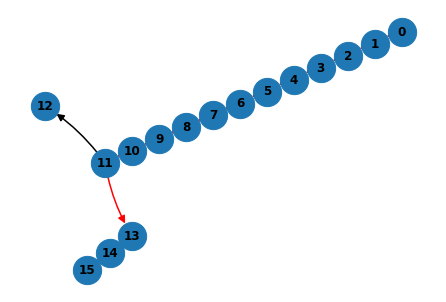

Clean logit difference: 30.959
Corrupted logit difference: -28.329
Positive Direction: >12
Negative Direction: >13


  0%|          | 0/6 [00:00<?, ?it/s]

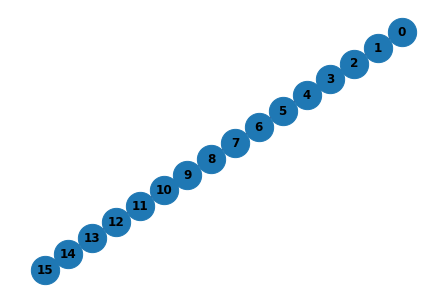

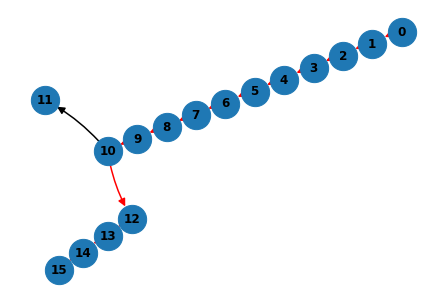

Clean logit difference: 28.172
Corrupted logit difference: -30.761
Positive Direction: >11
Negative Direction: >12


  0%|          | 0/6 [00:00<?, ?it/s]

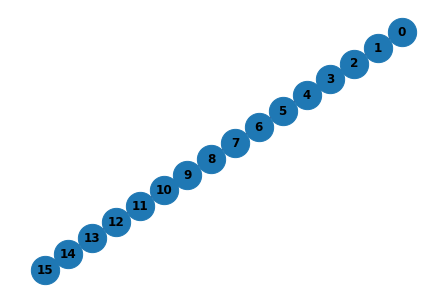

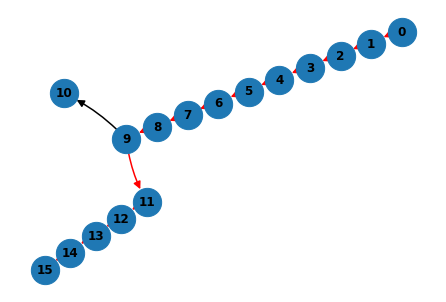

Clean logit difference: 27.548
Corrupted logit difference: -28.529
Positive Direction: >10
Negative Direction: >11


  0%|          | 0/6 [00:00<?, ?it/s]

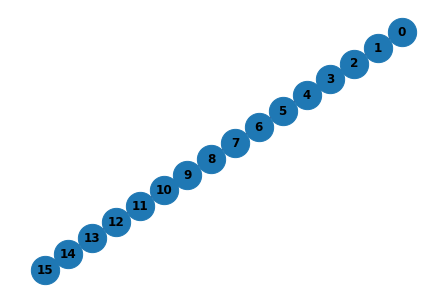

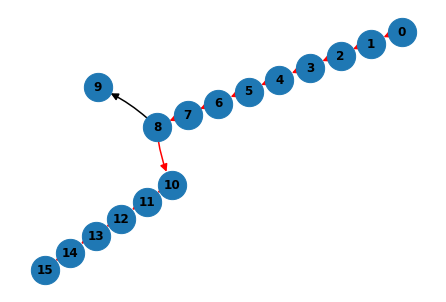

Clean logit difference: 24.128
Corrupted logit difference: -28.838
Positive Direction: >9
Negative Direction: >10


  0%|          | 0/6 [00:00<?, ?it/s]

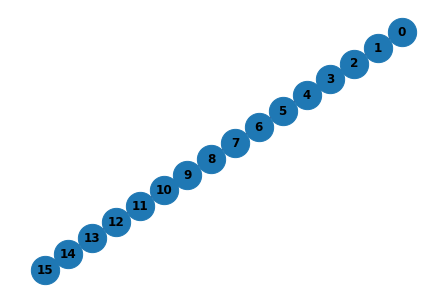

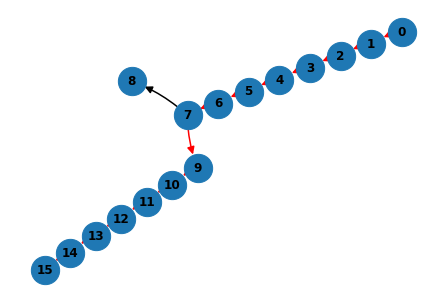

Clean logit difference: 27.738
Corrupted logit difference: -27.034
Positive Direction: >8
Negative Direction: >9


  0%|          | 0/6 [00:00<?, ?it/s]

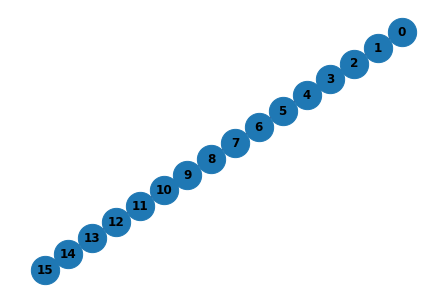

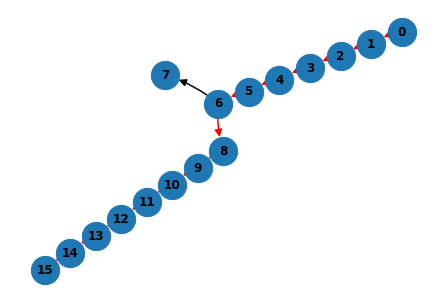

Clean logit difference: 28.092
Corrupted logit difference: -27.944
Positive Direction: >7
Negative Direction: >8


  0%|          | 0/6 [00:00<?, ?it/s]

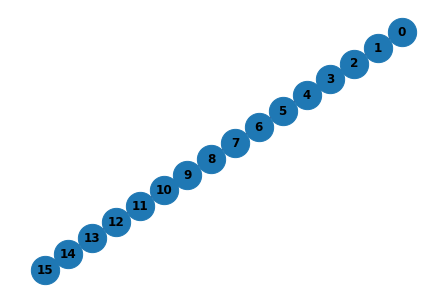

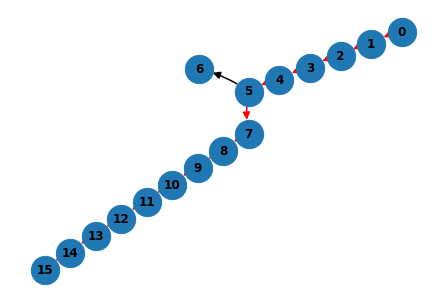

Clean logit difference: 26.328
Corrupted logit difference: -22.959
Positive Direction: >6
Negative Direction: >7


  0%|          | 0/6 [00:00<?, ?it/s]

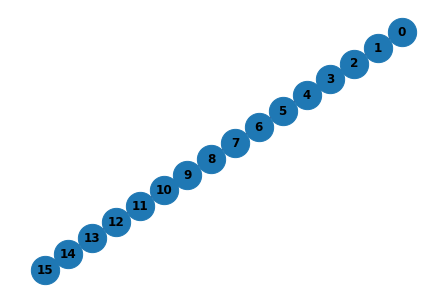

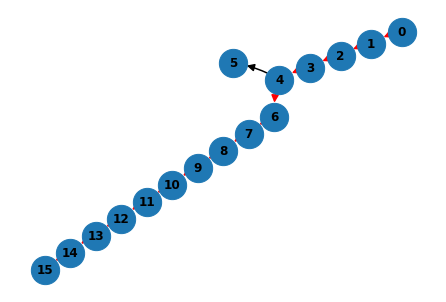

Clean logit difference: 23.962
Corrupted logit difference: -26.489
Positive Direction: >5
Negative Direction: >6


  0%|          | 0/6 [00:00<?, ?it/s]

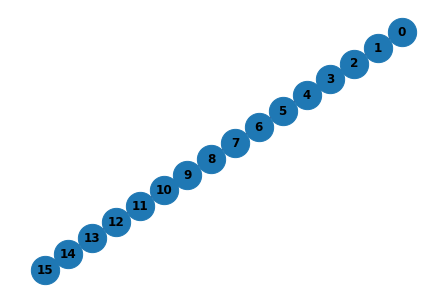

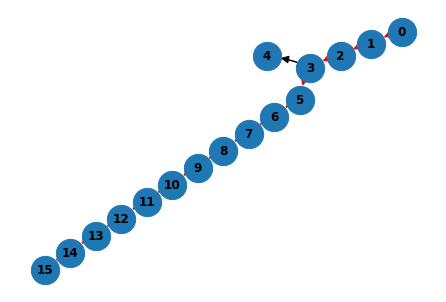

Clean logit difference: 28.749
Corrupted logit difference: -28.624
Positive Direction: >4
Negative Direction: >5


  0%|          | 0/6 [00:00<?, ?it/s]

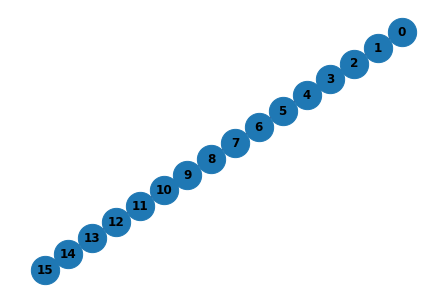

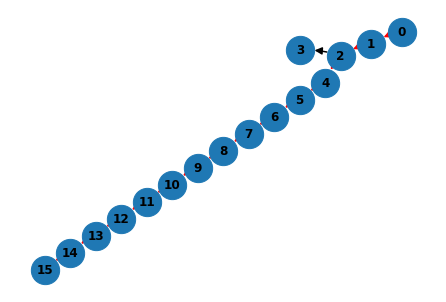

Clean logit difference: 23.565
Corrupted logit difference: -22.898
Positive Direction: >3
Negative Direction: >4


  0%|          | 0/6 [00:00<?, ?it/s]

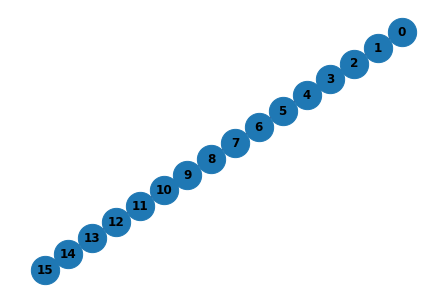

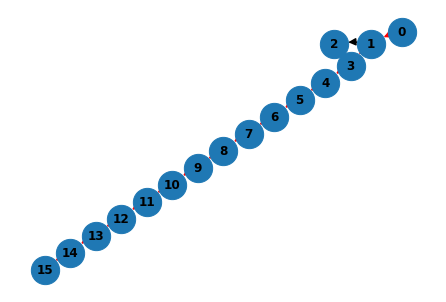

Clean logit difference: 21.542
Corrupted logit difference: -23.868
Positive Direction: >2
Negative Direction: >3


  0%|          | 0/6 [00:00<?, ?it/s]

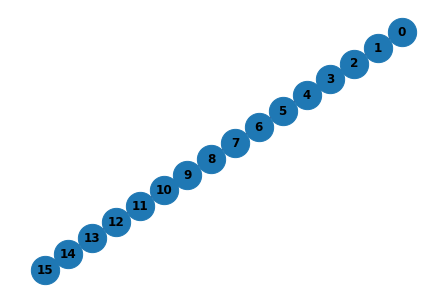

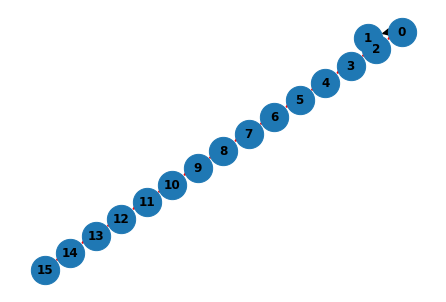

Clean logit difference: 19.914
Corrupted logit difference: -28.110
Positive Direction: >1
Negative Direction: >2


  0%|          | 0/6 [00:00<?, ?it/s]

In [23]:
model.reset_hooks()
patchings = [goal_distance_activation_patching(i) for i in range(1, 15)]

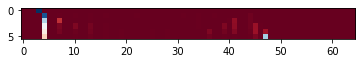

In [24]:
import matplotlib.animation as animation
from IPython.display import HTML

model.reset_hooks()
# Create a figure
fig = plt.figure()

# Function to update each frame
def update(i):
    plt.clf()
    plt.imshow(patchings[i][0].detach().cpu().numpy(), cmap='RdBu')

# Create animation

ani = animation.FuncAnimation(fig, update, frames=len(patchings), interval=200)
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, bitrate=1800)

# Save as mp4
ani.save('myAnimation.mp4', writer=writer)
HTML(ani.to_jshtml())


In [25]:
index = 6
%matplotlib inline
plot_activations(patchings[index][0], patchings[index][1], dataset)


In [26]:
patchings[index][0]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0